# 소행성 이미지를 WCS로 시각화하고 중심 찾기

* 이 노트북을 구글 코랩에서 실행하고자 한다면 [파일] - [드라이브에 사본 저장]을 하여 본인의 소유로 만든 후에 코드를 실행하거나 수정할 수 있습니다.

* 이 파일은 실제 수업에 사용하므로 필요에 따라 예고 없이 변경될 수 있습니다.

* If you have any questions or comments on this document, please email me(Kiehyun.Park@gmail.com).

* 이 파일(문서)는 공교육 현장에서 수업시간에 자유롭게 사용할 수 있으나, 다른 목적으로 사용할 시에는 사전에 연락을 주셔서 상의해 주시기 바랍니다.

이 자료는 천체 관측 자료인 FITS 파일을 열어 관련 정보를 알아보는 방법을 설명합니다.

## 필요한 환경

이 프로젝트를 위해서는 아래의 모듈이 필요합니다.

> numpy, matplotlib, astropy, ysfitsutilpy, ysphotutilpy, astroquery, version_information


### 구글 코랩에 한글 폰트 설치

matplotlib에서 한글을 사용하기 위해서는 한글 폰트가 필요하다. 구글 코랩에서 현재의 Jupyter notebook을 실행한다면 아래 코드를 실행 한 후 런타임 다시 시작을 해 줘야 한글을 사용할 수 있을 것이다.

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

### 런타임 다시 시작

위의 셀을 실행한 다음 반드시 다음 과정을 잊지 말자.

* [메뉴]-[런타임]-[런터임 다시 시작]

* [메뉴]-[런타임]-[이전 셀 실행]을 해주어야 한다.

### 한글 폰트 사용

위에서 한글 폰트를 설치하고, 런타임 다시시작을 했다면 구글 코랩에서 폰트 경로를 설정하여 한글 사용이 가능해 진다.

In [2]:
#visualization
import matplotlib as mpl
import matplotlib.pylab as plb
import matplotlib.pyplot as plt

# 브라우저에서 바로 그려지도록
%matplotlib inline

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic')

# 유니코드에서  음수 부호설정
mpl.rc('axes', unicode_minus=False)

### 모듈 설치 및 버전 확인

아래 셀을 실행하면 이 노트북을 실행하는데 필요한 모듈을 설치하고 파이썬 및 관련 모듈의 버전을 확인할 수 있습니다.

In [3]:
import importlib, sys, subprocess
packages = "numpy, matplotlib, astropy, ysfitsutilpy, ysphotutilpy, astroquery, version_information" # required modules
pkgs = packages.split(", ")
for pkg in pkgs :
    if not importlib.util.find_spec(pkg):
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg, '-q'])
        print(f"**** {pkg} module is now being installed.")
    else:
        print(f"******** {pkg} module is already installed.")
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information {packages}
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

******** numpy module is already installed.
******** matplotlib module is already installed.
******** astropy module is already installed.
******** ysfitsutilpy module is already installed.
******** ysphotutilpy module is already installed.
******** astroquery module is already installed.
******** version_information module is already installed.
This notebook was generated at 2023-10-01 10:16:59 (UTC = GMT+0000) 


/usr/local/lib/python3.10/dist-packages/ysphotutilpy/seputil.py:113: UserWarning: Package sep is not installed. Some functions will not work.
  warn("Package sep is not installed. Some functions will not work.")


0 Python     3.10.12 64bit [GCC 11.4.0]
1 IPython    7.34.0
2 OS         Linux 5.15.120+ x86_64 with glibc2.35
3 numpy      1.23.5
4 matplotlib 3.7.1
5 astropy    5.3.3
6 ysfitsutilpy 0.2
7 ysphotutilpy 0.1.1
8 astroquery 0.4.6
9 version_information 1.0.4


## 데이터 저장

### FITS 파일 저장 폴더 생성

FITS 파일을 저장할 폴더를 "Asteroid_fits_files" 이라는 이름으로 생성해보자.

* 만약 리눅스 시스템 이라면 shell 명령어로 가능한데, "!"를 붙이면 shell 명령어를 실행할 수 있습니다.
> !mkdir Asteroid_fits_files

OS의 영향을 받지 않기 위하여 pathlib을 사용하여 폴더를 생성해 보자.

In [4]:
import os
from pathlib import Path
BASEPATH = Path("./")
save_dir_name = "Asteroid_fits_files"
print(f"BASEPATH: {BASEPATH}")

if not (BASEPATH/save_dir_name).exists():
    os.mkdir(str(BASEPATH/save_dir_name))
    print (f"{str(BASEPATH/save_dir_name)} is created...")
else :
    print (f"{str(BASEPATH/save_dir_name)} is already exist...")

BASEPATH: .
Asteroid_fits_files is already exist...


### FITS 파일 다운로드

나의 구글 드라이브에 저장된 CCD 관측 파일을 다운받아 보겠습니다.

GNU Wget은 HTTP 통신 또는 FTP 통신을 사용해 서버에서 파일 또는 콘텐츠를 다운로드할 때 사용하는 소프트웨어입니다. Wget의 특징은 여러 파일을 한 번에 다운로드하거나 웹 페이지의 링크를 순회하며 여러 콘텐츠를 자동으로 다운로드할 때 매우 편리합니다.

MS Windows에서는 별도로 설치를 해줘야 하며,
구글 코랩도 wget을을 지원해주니 아래 셀을 실행하면 자신의 [작업 영역]에 저장된다. 하지만 이 파일은 이 런타임이 재실행 될때는 삭제됨에 유의하자.

아래 코드를 실행하면 여러분의 작업영역에 해당 파일을 저장할 것이다.



In [5]:
fname1 = "216KLEOPATRA_LIGHT_V_2022-09-28-10-37-59_20sec_RILA600_STX-16803_-19c_1bin.fits"
fid1 = "1vSxrbRie90-UGO7XD3_nzbOqTC_eww-q"

# wget을 이용(나의 구굴드라이브에서 공유한 파일을 구글 코랩에서 사용할 경우)
!wget --no-check-certificate "https://docs.google.com/uc?export=download&id={fid1}" -O {save_dir_name}/{fname1}

# gdown을 이용(나의 구굴드라이브에서 공유한 파일을 다운로드)
#!gdown {fid1} -O {save_dir_name}/{fname1}

--2023-10-01 10:17:05--  https://docs.google.com/uc?export=download&id=1vSxrbRie90-UGO7XD3_nzbOqTC_eww-q
Resolving docs.google.com (docs.google.com)... 108.177.126.138, 108.177.126.101, 108.177.126.102, ...
Connecting to docs.google.com (docs.google.com)|108.177.126.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-6c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7dqbcl2gr3n7f2abvld6bdc7rs6am5eq/1696155375000/11752785994579589476/*/1vSxrbRie90-UGO7XD3_nzbOqTC_eww-q?e=download&uuid=288db59a-bf21-494f-86ec-43bef4d3431b [following]
--2023-10-01 10:17:07--  https://doc-14-6c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7dqbcl2gr3n7f2abvld6bdc7rs6am5eq/1696155375000/11752785994579589476/*/1vSxrbRie90-UGO7XD3_nzbOqTC_eww-q?e=download&uuid=288db59a-bf21-494f-86ec-43bef4d3431b
Resolving doc-14-6c-docs.googleusercontent.com (doc-14-6c-docs.googleusercontent.com)... 173.194.79.132, 2a00:1

### 데이터 확인

* 코랩을 사용할 경우에는 오른쪽의 [파일]창에서 확인할 수 있습니다.
* linux shell 명령어로 다음과 같이 확인해 볼 수 있습니다.
> ls -l Asteroid_fits_files

OS의 영향을 받지 않고 파이썬으로 확인하는 방법은 아래와 같이 하면 됩니다.

In [6]:
fpaths = sorted(list((BASEPATH/save_dir_name).glob('*.fit*')))
print(f"fpaths: {fpaths}")
print(f"len(fpaths): {len(fpaths)}")

fpaths: [PosixPath('Asteroid_fits_files/216KLEOPATRA_LIGHT_B_2022-11-05-11-41-10_240sec_RILA600_STX-16803_-20c_1bin.fits'), PosixPath('Asteroid_fits_files/216KLEOPATRA_LIGHT_V_2022-09-28-10-37-59_20sec_RILA600_STX-16803_-19c_1bin.fits'), PosixPath('Asteroid_fits_files/216KLEOPATRA_LIGHT_V_2022-10-07-11-08-10_60sec_RILA600_STX-16803_-19c_1bin.fits'), PosixPath('Asteroid_fits_files/216KLEOPATRA_LIGHT_V_2022-10-07-12-14-10_80sec_RILA600_STX-16803_-19c_1bin.fits'), PosixPath('Asteroid_fits_files/216KLEOPATRA_LIGHT_V_2022-11-05-12-26-23_60sec_RILA600_STX-16803_-20c_1bin.fits'), PosixPath('Asteroid_fits_files/eph-216-216KLEOPATRA_LIGHT_B_2022-11-05-11-41-10_240sec_RILA600_STX-16803_-20c_1bin.fits.csv'), PosixPath('Asteroid_fits_files/eph-216-216KLEOPATRA_LIGHT_V_2022-09-28-10-37-59_20sec_RILA600_STX-16803_-19c_1bin.fits.csv')]
len(fpaths): 7


## astrometry solving

이미 plate solving이 되어 있는 파일은 이 섹션을 무시하셔도 됩니다. 만약 plate solving을 수행하고자 한다면 아래 셀들의 주석을 지우고 실행해 주십시오.

### apstrometry 연결

nova.astrometry.net 으로부터 api key를 이용하여 연결합니다.


In [7]:
# from astroquery.astrometry_net import AstrometryNet

# ast = AstrometryNet()

# # ger from nova.astrometry.net
# ast.api_key = 'bldvwzzuvktnwfph1234' #must changed...


### plate solving using astrometry

아래와 같이 하면 plate solving을 한번에 할 수 있습니다. 시간이 많이 소요되니 기다리시길 바랍니다.

In [8]:
# import shutil
# from astropy.io import fits

# submission_id = None
# solve_timeout = 600
# for fpath in fpaths:
#     print(fpath)
#     hdul = fits.open(str(fpath))
#     if not 'B_1_1' in hdul[0].header :
#         try_again = True

#     while try_again:
#         try:
#             if not submission_id:
#                 wcs_header = ast.solve_from_image(str(fpath),
#                                     force_image_upload=True,
#                                     solve_timeout = solve_timeout,
#                                     submission_id=submission_id)
#             else:
#                 wcs_header = ast.monitor_submission(submission_id,
#                                                     solve_timeout = solve_timeout)
#         except TimeoutError as e:
#             submission_id = e.args[1]
#         else:
#             # got a result, so terminate
#             try_again = False

#     if wcs_header:
#         # Code to execute when solve succeeds
#         print("fits file solved successfully...")
#         shutil.copy(str(fpath), str(fpath.parents[0] / f"{fpath.stem}.tmp"))

#         with fits.open(str(fpath.parents[0] / f"{fpath.stem}.tmp"), mode='update') as filehandle:
#             #print("filehandle[0].header :", filehandle[0].header)
#             for card in wcs_header :
#                 try:
#                     print(card, wcs_header[card], wcs_header.comments[card])
#                     filehandle[0].header.set(card, wcs_header[card], wcs_header.comments[card])
#                 except :
#                     print(card)
#             filehandle.flush
#         shutil.move(str(fpath.parents[0] / f"{fpath.stem}.tmp"), str(fpath.parents[0] / f"{fpath.stem}.fits"))
#         print(str(fpath.parents[0] / f'{fpath.stem}.fits')+" is created...")
#     else:
#         # Code to execute when solve fails
#         print("fits file solving failure...")

##  FITS handling

### Load files

fits file들을 모두 읽어들여 ccds라는 이름의 리스트에 저장해 놓고 사용하겠습니다.



In [9]:
from astropy.io import fits

fpath = Path(fpaths[0])
print(f"fpath: {fpath}")
print(f"type(fpath): {type(fpath)}")

ccd = fits.open(str(fpath), unit="adu")

print("type(ccd) :", type(ccd))
print("type(ccd[0]) :", type(ccd[0]))

fpath: Asteroid_fits_files/216KLEOPATRA_LIGHT_B_2022-11-05-11-41-10_240sec_RILA600_STX-16803_-20c_1bin.fits
type(fpath): <class 'pathlib.PosixPath'>
type(ccd) : <class 'astropy.io.fits.hdu.hdulist.HDUList'>
type(ccd[0]) : <class 'astropy.io.fits.hdu.image.PrimaryHDU'>


### header

ccds라는 이름에 HDUList들이 리스트 형태로 들어 있습니다. 각각의 hdulist는 2차원 이므로 index는 [0]번만 존재합니다.

In [10]:
print("type(ccd[0].hedaer) :", type(ccd[0].header))
ccd[0].header

type(ccd[0].hedaer) : <class 'astropy.io.fits.header.Header'>


SIMPLE  =                    T / C# FITS                                        
BITPIX  =                   16 /                                                
NAXIS   =                    2 / Dimensionality                                 
NAXIS1  =                 4096 /                                                
NAXIS2  =                 4096 /                                                
EXTEND  =                    T / Extensions are permitted                       
IMAGETYP= 'LIGHT'              / Type of exposure                               
EXPOSURE=                240.0 / [s] Exposure duration                          
EXPTIME =                240.0 / [s] Exposure duration                          
DATE-LOC= '2022-11-05T20:41:10.009' / Time of observation (local)               
DATE-OBS= '2022-11-05T11:41:10.009' / Time of observation (UTC)                 
XBINNING=                    1 / X axis binning factor                          
YBINNING=                   

header는 key와 value가 들어 있습니다.

In [11]:
print("ccd[0].hedaer['DATE-OBS'] :", ccd[0].header['DATE-OBS'])
print("type(ccd[0].hedaer['DATE-OBS']) :", type(ccd[0].header['DATE-OBS']))

ccd[0].hedaer['DATE-OBS'] : 2022-11-05T11:41:10.009
type(ccd[0].hedaer['DATE-OBS']) : <class 'str'>


### data

관측 자료는 numpy.ndarray 형태로 들어 있음을 알 수 있습니다.

In [12]:
print("type(ccd[0].data) :", type(ccd[0].data))
print("ccd[0].data.dtype :", ccd[0].data.dtype)
print("ccd[0].data.shape :", ccd[0].data.shape)
print("ccd[0].data :", ccd[0].data)

type(ccd[0].data) : <class 'numpy.ndarray'>
ccd[0].data.dtype : uint16
ccd[0].data.shape : (4096, 4096)
ccd[0].data : [[3711 3718 3645 ... 3647 3648 1125]
 [3798 3795 3660 ... 3653 3687 1116]
 [5167 3781 3717 ... 3606 3591 1124]
 ...
 [3723 3755 3709 ... 3513 3615 1162]
 [3646 3660 3767 ... 3470 3511 1205]
 [3690 3718 3742 ... 3568 3590 1163]]


## WCS

### 관측소 정보 및 변수 설정


In [13]:
#####################################################################
# Our object (will be queried to JPL HORIZONS)
OBJID = '216' # Kleopatra

# Observed location
LOCATION = dict(lon=127.005, lat=37.308889, elevation=130)

from astropy import units as u
# It is used as a rough estimate, so no need to be accurate:
PIX2ARCSEC = 0.62*u.arcsec

# Used for any `astropy.SkyCoord` object:
SKYC_KW = dict(unit=u.deg, frame='icrs')

### WCS 얻기

In [14]:
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

wcs = WCS(ccd[0].header)
print("wcs :", wcs)
print("type(wcs) :", type(wcs))
print("dir(wcs) :", dir(wcs))
wcs.pixel_n_dim

wcs : WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 341.2377375475  1.901863705748  
CRPIX : 2048.5  2048.5  
CD1_1 CD1_2  : -3.251527278006e-06  0.00017228633925  
CD2_1 CD2_2  : -0.0001724796990691  -3.325864456979e-06  
NAXIS : 4096  4096
type(wcs) : <class 'astropy.wcs.wcs.WCS'>
dir(wcs) : ['__abstractmethods__', '__class__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_all_pix2world', '_all_world2pix', '_array_converter', '_as_mpl_axes', '_denormalize_sky', '_det2im', '_fix_ctype', '_fix_pre2012_scamp_tpv', '_fix_scamp', '_get_components_and_classes', '_get_naxis', '_init_kwargs', '_naxis', '_normaliz

2

### 소행성 좌표 정보

관측소 정보와 관측 파일의 header에 있는 정보로 소행성 좌표를 얻어보자.

In [82]:
import ysphotutilpy as ypu
help(ypu)
help(ypu.queryutil)

Help on package ysphotutilpy:

NAME
    ysphotutilpy

PACKAGE CONTENTS
    aperture
    apphot
    astroim
    background
    center
    daopsf
    growth
    polarimetry
    query_cols
    queryutil
    radprof
    seputil
    smallbody
    tests (package)
    util

DATA
    gaia_dr3_source_phot = ['solution_id', 'source_id', 'ref_epoch', 'ra',...

FILE
    /usr/local/lib/python3.10/dist-packages/ysphotutilpy/__init__.py


Help on module ysphotutilpy.queryutil in ysphotutilpy:

NAME
    ysphotutilpy.queryutil

CLASSES
    builtins.object
        HorizonsDiscreteEpochsQuery
        MASTQuery
        PanSTARRS1
    
    class HorizonsDiscreteEpochsQuery(builtins.object)
     |  HorizonsDiscreteEpochsQuery(targetname, location, epochs, id_type='smallbody')
     |  
     |  Methods defined here:
     |  
     |  __init__(self, targetname, location, epochs, id_type='smallbody')
     |      Designed to query JPL Horizons for a **large** list of epochs.
     |      Parameters
     |      ---

In [15]:
import ysphotutilpy as ypu
from astropy.time import Time
_, eph, _ = ypu.horizons_query(OBJID,
                               epochs=Time(ccd[0].header["DATE-OBS"]).jd,
                               location=LOCATION)

print("type(eph) :", type(eph))
print("eph :", eph)

type(eph) : <class 'astropy.table.table.Table'>
eph :        targetname             datetime_str       ...  PABLon  PABLat
          ---                     ---            ...   deg     deg  
----------------------- ------------------------ ... -------- ------
216 Kleopatra (A880 GB) 2022-Nov-05 11:41:10.009 ... 355.2987 7.9345


## dataframe으로 저장하기

여러개의 관측 데이터를 다룰 때는 dataframe이 유용할 수 있으므로 아래와 같이 dataframe으로 변환해 보자.

In [16]:
import pandas as pd
df_eph = eph.to_pandas()
df_eph

,targetname,datetime_str,datetime_jd,H,G,solar_presence,flags,RA,DEC,RA_app,...,r_3sigma,r_rate_3sigma,SBand_3sigma,XBand_3sigma,DoppDelay_3sigma,true_anom,hour_angle,alpha_true,PABLon,PABLat
0,216 Kleopatra (A880 GB),2022-Nov-05 11:41:10.009,2.459889e+06,7.08,0.29,,m,341.24241,2.04304,341.53266,...,22.977,0.000002,0.02,0.07,0.000153,331.3335,0.363336,23.5159,355.2987,7.9345


### 저장하기


In [17]:
df_eph.to_csv(f"{save_dir_name}/eph-{OBJID}-{fpath.name}.csv")
if (BASEPATH/save_dir_name/f'eph-{OBJID}-{fpath.name}.csv').exists() :
    print(f"{save_dir_name}/eph-{OBJID}-{fpath.name}.csv is created...")

Asteroid_fits_files/eph-216-216KLEOPATRA_LIGHT_B_2022-11-05-11-41-10_240sec_RILA600_STX-16803_-20c_1bin.fits.csv is created...


### 소행성 좌표 얻기


In [18]:
for _, row in df_eph.iterrows():
    print("row['targetname'] :", row['targetname'],
          "row['datetime_str'] :", row['datetime_str'],
          "row['datetime_jd'] :", row['datetime_jd'],
          "row['RA'] :", row['RA'],
          "row['DEC'] :", row['DEC'],
          )


row['targetname'] : 216 Kleopatra (A880 GB) row['datetime_str'] : 2022-Nov-05 11:41:10.009 row['datetime_jd'] : 2459888.9869214 row['RA'] : 341.24241 row['DEC'] : 2.04304


## Display FITS file

matplotlib을 이용하면 numpy.ndarray를 화면에 디스플레이할 수 있습니다.

### display 하기

wcs 이용하여 display

fpath Asteroid_fits_files/216KLEOPATRA_LIGHT_B_2022-11-05-11-41-10_240sec_RILA600_STX-16803_-20c_1bin.fits


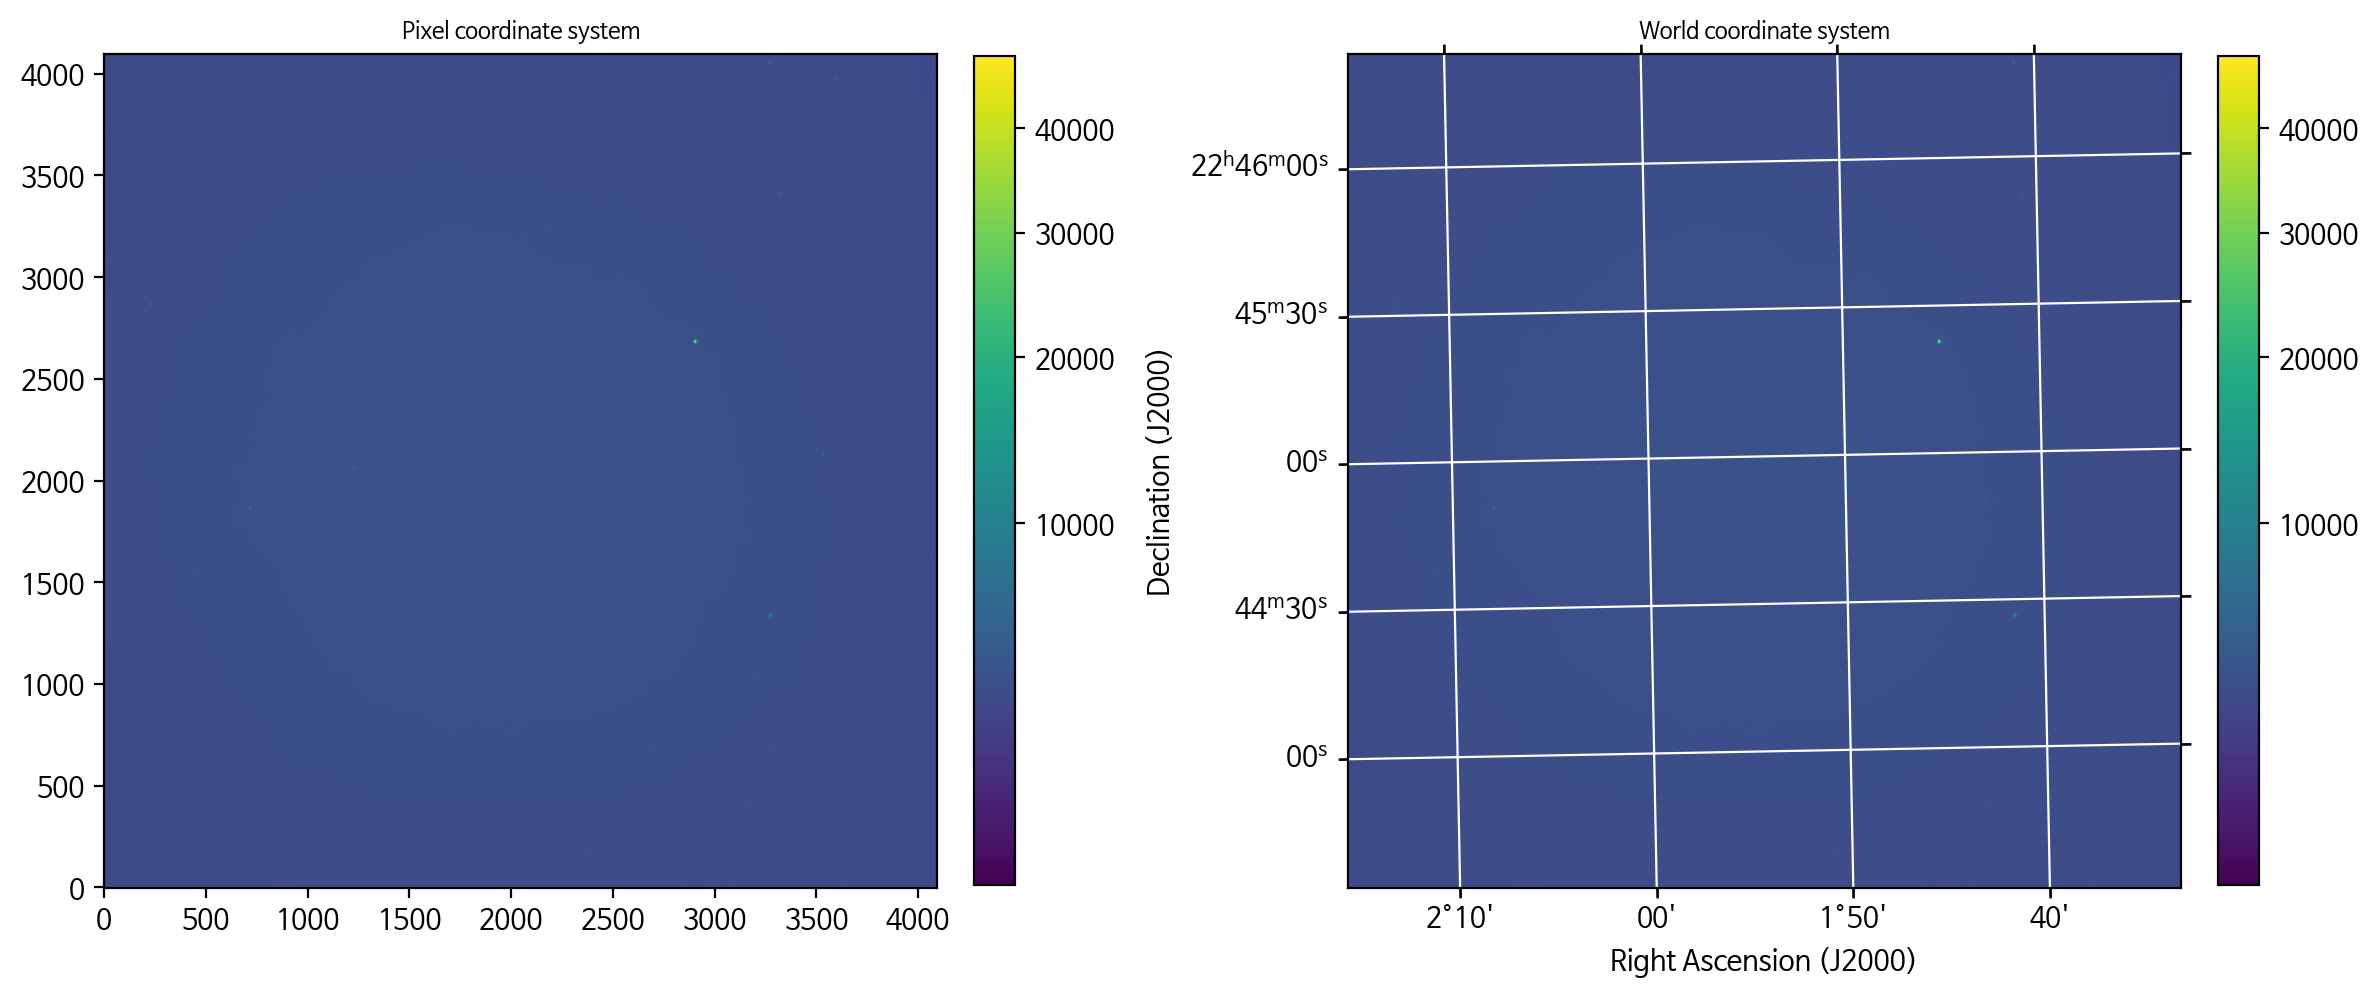

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import (MinMaxInterval, SqrtStretch,
                                   ImageNormalize)

# Create an ImageNormalize object
norm = ImageNormalize(ccd[0].data, interval=MinMaxInterval(),
                      stretch=SqrtStretch())

print("fpath", (fpath))

wcs = WCS(ccd[0].header)

fig_set = plt.figure(figsize=(12, 24))

ax1 = plt.subplot2grid((1,2), (0,0),
                       fig=fig_set)

im1 = ax1.imshow(ccd[0].data,
            origin='lower',
            norm=norm,
            )
ax1.set_title('Pixel coordinate system', fontsize=8)

ax2 = plt.subplot2grid((1,2), (0,1),
                    projection=wcs,
                    fig=fig_set)

im2 = ax2.imshow(ccd[0].data,
            origin='lower',
            norm=norm,
            )
ax2.set_title('World coordinate system', fontsize=8)

ax2.coords.grid(True, color='white', ls='solid')
ax2.coords['ra'].set_axislabel('Right Ascension (J2000)')
ax2.coords['ra'].set_ticklabel_position('bl')
ax2.coords['dec'].set_axislabel('Declination (J2000)')
ax2.coords['dec'].set_ticklabel_position('bl')

plt.colorbar(im1, ax = ax1, fraction=0.0455, pad=0.04)
plt.colorbar(im2, ax = ax2, fraction=0.0455, pad=0.04)
plt.tight_layout()

### 소행성 좌표의 픽셀 주소


In [21]:
pos_targ_inits = []
for i, row in df_eph.iterrows():
    # print("row['targetname'] :", row['targetname'],
    #       "row['datetime_str'] :", row['datetime_str'],
    #       "row['datetime_jd'] :", row['datetime_jd'],
    #       "row['RA'] :", row['RA'],
    #       "row['DEC'] :", row['DEC'],
    #       )
    wcs = WCS(ccd[0].header)
    pos_targ_init = SkyCoord(row['RA'], row["DEC"],
						**SKYC_KW).to_pixel(wcs)
    #print("type(pos_targ_init) :", type(pos_targ_init))
    pos_targ_inits.append(pos_targ_init)
#print(pos_targ_inits)

df_eph['pos_targ_init'] = pos_targ_inits
print("df_eph['pos_targ_init'] :", df_eph['pos_targ_init'])

df_eph['pos_targ_init'] : 0    (1228.739106133487, 2059.188610185128)
Name: pos_targ_init, dtype: object


### 소행성 tag

fpath Asteroid_fits_files/216KLEOPATRA_LIGHT_B_2022-11-05-11-41-10_240sec_RILA600_STX-16803_-20c_1bin.fits


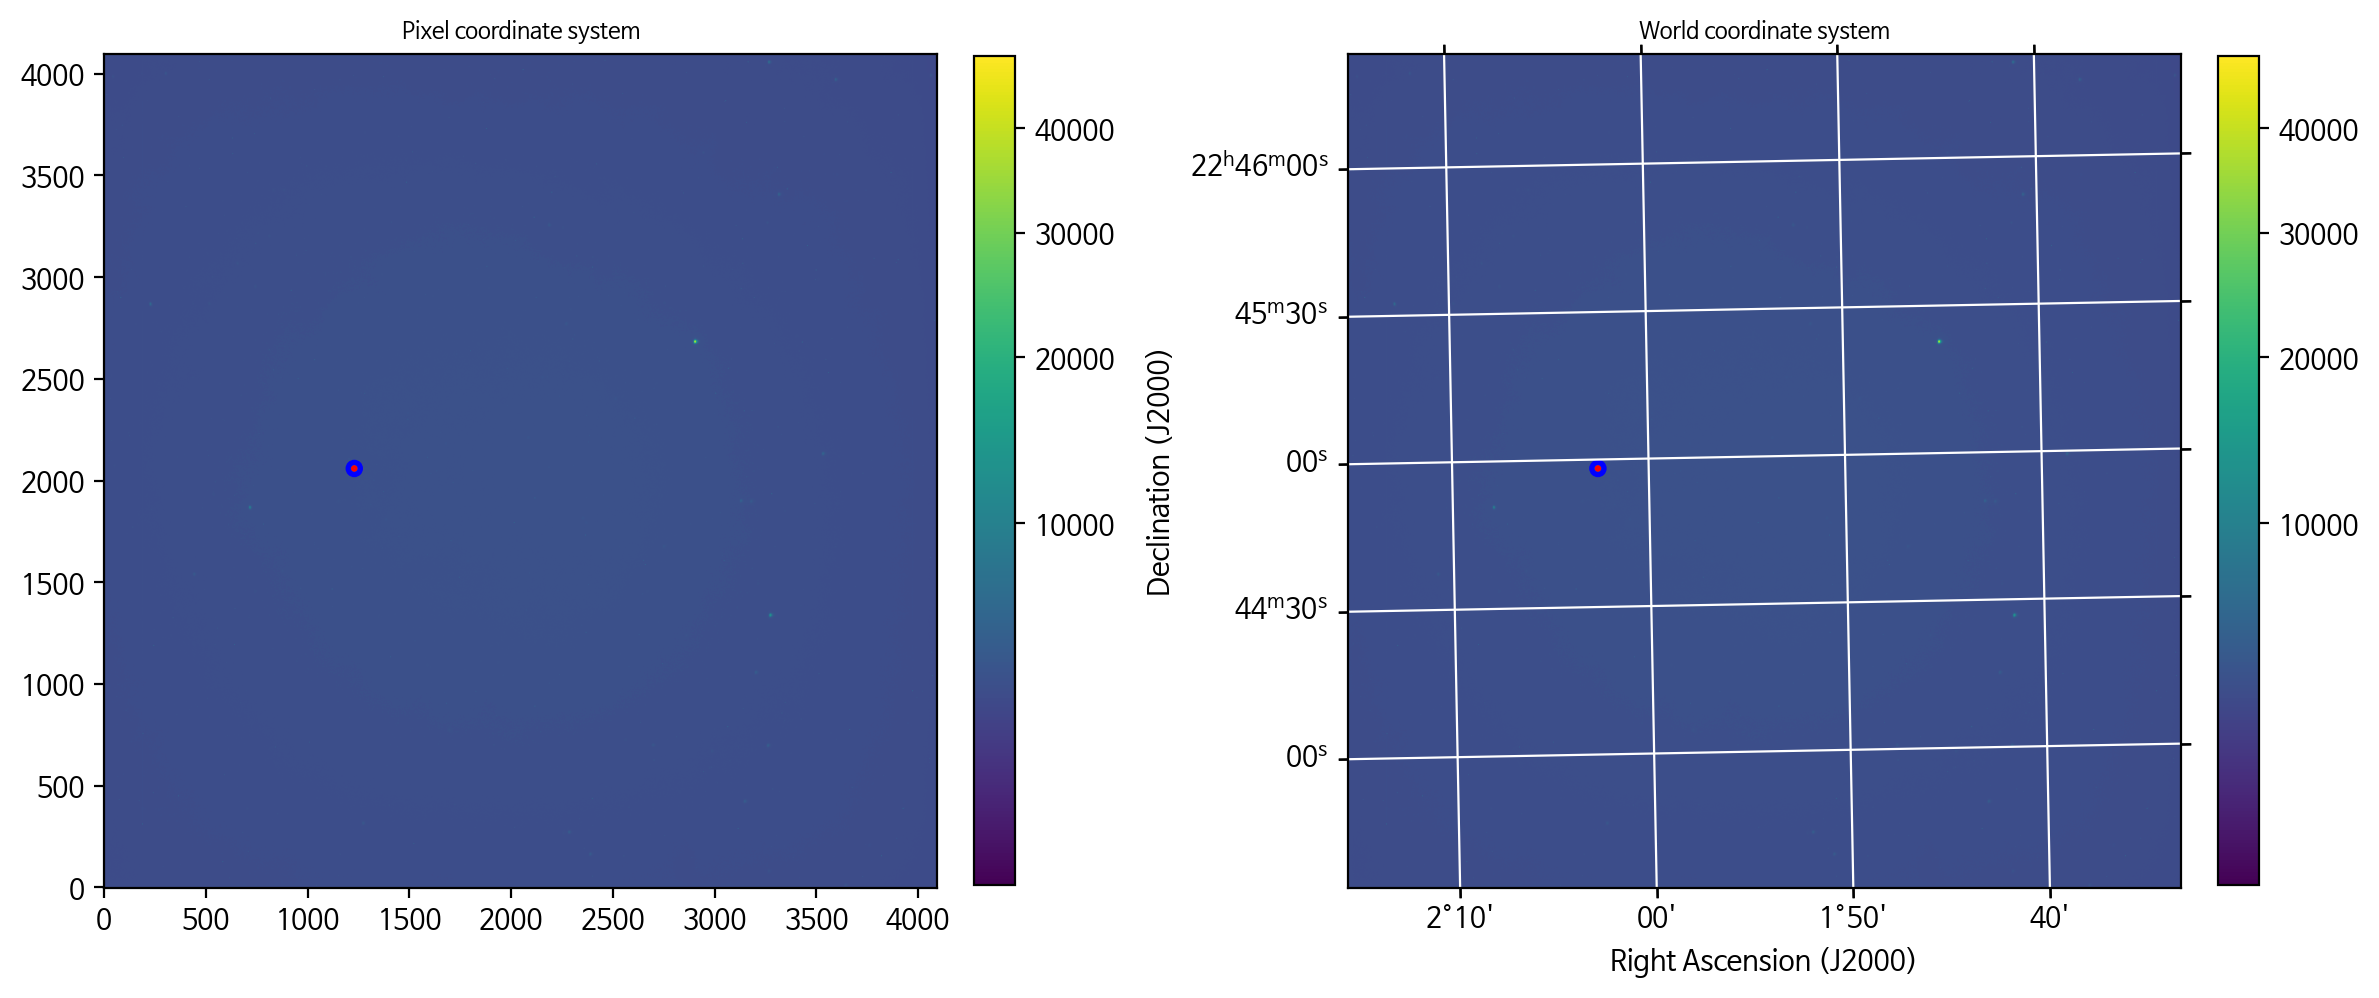

In [26]:
#######################################################
# Initial guess of FWHM in pixel
FWHM_INIT = 6

# Photometry parameters
R_AP = 1.5*FWHM_INIT # Aperture radius
R_IN = 4*FWHM_INIT   # Inner radius of annulus
R_OUT = 6*FWHM_INIT  # Outer radius of annulus
#######################################################

import numpy as np
import matplotlib.pyplot as plt
from photutils.aperture import CircularAperture as CAp
from photutils.aperture import CircularAnnulus as CAn

targ_ap = CAp(df_eph['pos_targ_init'][0],
        r=R_AP)
targ_an = CAn(df_eph['pos_targ_init'][0],
        r_in=R_IN,
        r_out=R_OUT)


print("fpath", (fpath))

wcs = WCS(ccd[0].header)

fig_set = plt.figure(figsize=(12, 24))

ax1 = plt.subplot2grid((1,2), (0,0),
                       fig=fig_set)

im1 = ax1.imshow(ccd[0].data,
            origin='lower',
            norm=norm,
            )
targ_ap.plot(ax1, color="r")
targ_an.plot(ax1, color="b")
ax1.set_title('Pixel coordinate system', fontsize=8)
plt.colorbar(im1, ax = ax1, fraction=0.0455, pad=0.04)

ax2 = plt.subplot2grid((1,2), (0,1),
                    projection=wcs,
                    fig=fig_set)

im2 = ax2.imshow(ccd[0].data,
            origin='lower',
            norm=norm,
            )
targ_ap.plot(ax2, color="r")
targ_an.plot(ax2, color="b")

ax2.set_title('World coordinate system', fontsize=8)

ax2.coords.grid(True, color='white', ls='solid')
ax2.coords['ra'].set_axislabel('Right Ascension (J2000)')
ax2.coords['ra'].set_ticklabel_position('bl')
ax2.coords['dec'].set_axislabel('Declination (J2000)')
ax2.coords['dec'].set_ticklabel_position('bl')

plt.colorbar(im2, ax = ax2, fraction=0.0455, pad=0.04)
plt.tight_layout()

plt.show()

### 소행성 주변만 자르기

In [55]:
from astropy.nddata import Cutout2D
from astropy.stats import sigma_clip, sigma_clipped_stats
from photutils.centroids import centroid_com

#1. cut asteroia area
cutsizes = 49
cut_hdu = Cutout2D(
            data = ccd[0].data,
            position = (df_eph['pos_targ_init'][0]),
            size=(cutsizes, cutsizes) #cut ccd
            )
avg, med, std = sigma_clipped_stats(cut_hdu.data)  # by default, 3-sigma 5-iteration.

#2. Get center dx, dy
thresh_3sig = med + 3 * std
mask_3sig = (cut_hdu.data < thresh_3sig)
center = centroid_com(
            data = cut_hdu.data,
            mask = mask_3sig
            )

centerdx = round(cutsizes/2)-center[0]
centerdy = round(cutsizes/2)-center[1]

print("type(center):", type(center))
print("center:", center)
print("center dx, dy:", centerdx, centerdy)

type(center): <class 'numpy.ndarray'>
center: [25.27516439 26.15464413]
center dx, dy: -1.2751643885863295 -2.1546441321906897


In [56]:
from photutils import aperture_photometry as apphot

#3. Loading and RE-Cut Data with New center
bigcutsizes = 101
bigcut_hdu = Cutout2D(
            data = ccd[0].data,
            position = (df_eph['pos_targ_init'][0]),
            size=(bigcutsizes, bigcutsizes) #cut ccd
            )
avg, med, std = sigma_clipped_stats(bigcut_hdu.data)  # by default, 3-sigma 5-iteration.

#4. re center Aperture and Annulus
bigcenter = [round(bigcutsizes/2) - centerdx, round(bigcutsizes/2) - centerdy]

ap = CAp(positions = bigcenter,
        r=R_AP)
an = CAn(positions = bigcenter,
        r_in=R_IN,
        r_out=R_OUT)

print("ap", ap)
print("type(ap)", type(ap))
print("an", an)
print("type(an)", type(an))

# 5. Estimating Sky
sky_mask = an.to_mask(method = 'center')

try:  # prior to photutils 0.7
    sky_vals = sky_mask[0].multiply(bigcut_hdu.data)
except TypeError:
    sky_vals = sky_mask.multiply(bigcut_hdu.data)

sky_vals = sky_vals[sky_vals > 0]
avg, med, std = sigma_clipped_stats(
            sky_vals,
            sigma=3,
            maxiters=10,
            std_ddof=1
            )

if med - avg < 0.3 * std:
    msky = med
else:
    msky = 2.5 * med - 1.5 * avg

print(f"Sky estimation: {msky:.3f} +- {std:.3f}")

phot = apphot(
    data = bigcut_hdu.data,
    apertures = ap
    )
phot["sky"] = msky

try:  # prior to photutils 0.7
    phot["source_sum"] = phot["aperture_sum"] - ap.area() * phot["sky"]

except TypeError:
    phot["source_sum"] = phot["aperture_sum"] - ap.area * phot["sky"]

phot["inst_mag"] = -2.5 * np.log10(phot["source_sum"] / ccd[0].header["EXPTIME"])
print("phot:", phot)

ap Aperture: CircularAperture
positions: [51.27516439, 52.15464413]
r: 9.0
type(ap) <class 'photutils.aperture.circle.CircularAperture'>
an Aperture: CircularAnnulus
positions: [51.27516439, 52.15464413]
r_in: 24.0
r_out: 36.0
type(an) <class 'photutils.aperture.circle.CircularAnnulus'>
Sky estimation: 3912.000 +- 49.296
phot:  id      xcenter      ...     source_sum          inst_mag     
           pix        ...                                      
--- ----------------- ... ----------------- -------------------
  1 51.27516438858633 ... 322090.6839952294 -7.8194173048831015


<ipython-input-56-8aa20c3414f4>:1: DeprecationWarning: `photutils.aperture_photometry` is a deprecated alias for `photutils.aperture.aperture_photometry` and will be removed in the future. Instead, please use `from photutils.aperture import aperture_photometry` to silence this warning.
  from photutils import aperture_photometry as apphot


### 소행성 영역 display

소행성의 중심은 어디인가?

fpath Asteroid_fits_files/216KLEOPATRA_LIGHT_B_2022-11-05-11-41-10_240sec_RILA600_STX-16803_-20c_1bin.fits


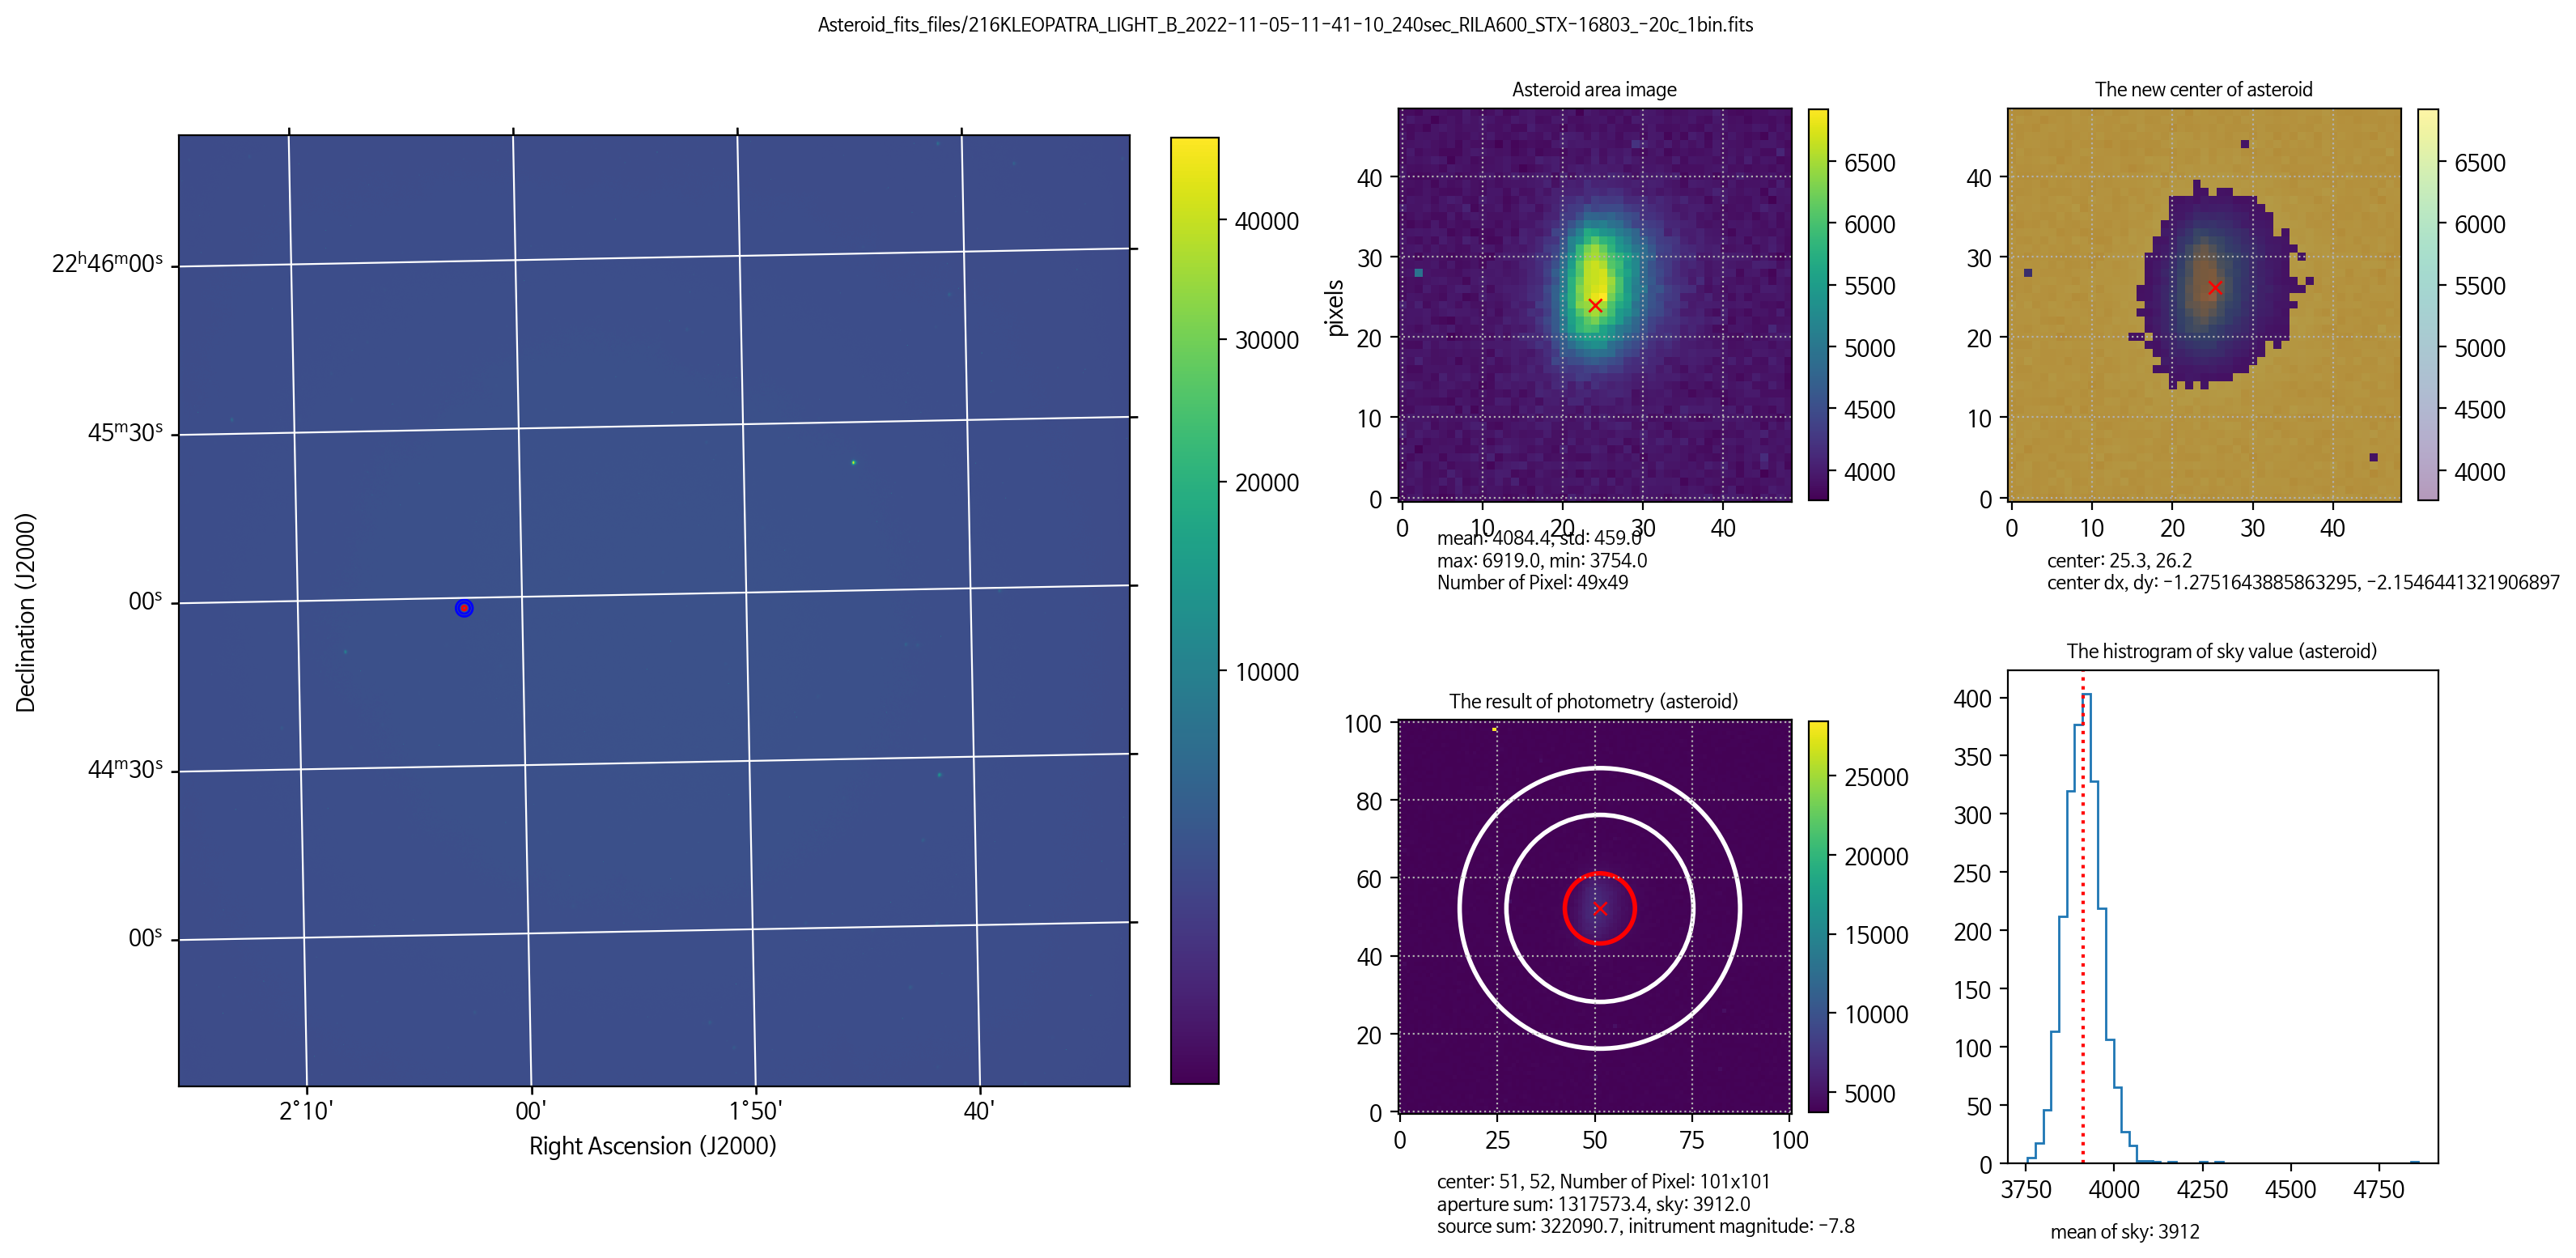

In [57]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.visualization import simple_norm

# Create an ImageNormalize object
norm = simple_norm(ccd[0].data, 'sqrt')

print("fpath", (fpath))

fig_set = plt.figure(figsize=(16, 8))

ax1 = plt.subplot2grid((2,4), (0,0),
                    colspan=2, rowspan=2,
                    projection=wcs,
                    fig=fig_set)
im1 = ax1.imshow(ccd[0].data,
            origin='lower',
            norm=norm,
            )
targ_ap.plot(ax1, color="r")
targ_an.plot(ax1, color="b")
ax1.coords.grid(True, color='white', ls='solid')
ax1.coords['ra'].set_axislabel('Right Ascension (J2000)')
ax1.coords['ra'].set_ticklabel_position('bl')
ax1.coords['dec'].set_axislabel('Declination (J2000)')
ax1.coords['dec'].set_ticklabel_position('bl')
plt.colorbar(im1,
             ax = ax1,
             fraction=0.0455, pad=0.04)

ax20 = plt.subplot2grid((2,4), (0,2),
                       fig=fig_set)
im20 = ax20.imshow(cut_hdu.data,
    origin='lower'
    )
ax20.plot(round(cutsizes/2), round(cutsizes/2), 'rx')
ax20.set_ylabel('pixels')
ax20.grid(ls=':')
ax20.set_title(f'Asteroid area image', fontsize=8)
ax20.annotate(   f"mean: {np.mean(cut_hdu.data):.01f}, std: {np.std(cut_hdu.data):.01f} \nmax: {np.max(cut_hdu.data):.01f}, min: {np.min(cut_hdu.data):.01f} \nNumber of Pixel: {np.shape(cut_hdu.data)[0]:.0f}x{np.shape(cut_hdu.data)[1]:.0f}",
    xy=(0, 0), xytext=(0.1, -0.22),
    xycoords='axes fraction',
    fontsize=8)
plt.colorbar(im20,
            ax=ax20,
            fraction=0.0455, pad=0.04)

ax21 = plt.subplot2grid((2,4), (0,3),
                       fig=fig_set)
ax21.grid(ls=':')
ax21.set_title(f'The new center of asteroid', fontsize=8)
im21 = ax21.imshow(mask_3sig.astype(int),
    origin="lower")
im21 = ax21.imshow(cut_hdu.data,
        alpha=0.4,
        origin="lower")
ax21.plot(*center, 'rx')
ax21.annotate(f"center: {center[0]:.01f}, {center[1]:.1f}\ncenter dx, dy: {centerdx}, {centerdy}",
    xy=(0, 0), xytext=(0.1, -0.22),
    xycoords='axes fraction',
    fontsize=8)
plt.colorbar(im21,
            ax=ax21,
            fraction=0.0455, pad=0.04)

ax30 = plt.subplot2grid((2,4), (1,2),
                       fig=fig_set)
ax30.grid(ls=':')
ax30.set_title(f'The result of photometry (asteroid)', fontsize=8)
im30 = ax30.imshow(bigcut_hdu.data,
        origin='lower' )
ap.plot(ax30, color='r', lw=2)
an.plot(ax30, color='w', lw=2)
ax30.plot(*bigcenter, 'rx')
ax30.annotate(f"center: {bigcenter[0]:.0f}, {bigcenter[1]:.0f}, Number of Pixel: {np.shape(bigcut_hdu.data)[0]:.0f}x{np.shape(bigcut_hdu.data)[1]:.0f}\naperture sum: {float(phot['aperture_sum']):.01f}, sky: {float(phot['sky']):.01f}\nsource sum: {float(phot['source_sum']):.01f}, initrument magnitude: {float(phot['inst_mag']):.01f}",
    xy=(0, 0), xytext=(0.1, -0.3),
    xycoords='axes fraction',
    fontsize=8)

plt.colorbar(im30,
            ax=ax30,
            fraction=0.0455, pad=0.04)

ax31 = plt.subplot2grid((2,4), (1,3),
                       fig=fig_set)
ax31.set_title(f'The histrogram of sky value (asteroid)', fontsize=8)
ax31.hist(sky_vals, 50, histtype='step')
ax31.axvline(msky, ls=':', color='r')
ax31.annotate(f'mean of sky: {msky:.0f}',
    xy=(0.5, -0.3), xytext=(0.1, -0.15),
    xycoords='axes fraction',
    fontsize=8)

plt.suptitle(f'{str(fpaths[0])}', fontsize=8)
plt.tight_layout()
plt.show()

### asteroid 중심의 pixel 좌표

In [58]:
print(df_eph['pos_targ_init'])
pos_targ_from_fits = (df_eph['pos_targ_init'][0][0] - centerdx, df_eph['pos_targ_init'][0][1] - centerdy )
print(pos_targ_from_fits)

0    (1228.739106133487, 2059.188610185128)
Name: pos_targ_init, dtype: object
(1230.0142705220733, 2061.3432543173185)


### (질문) 사진에서 판단한 소행성의 적도 좌표

* 사진으로 판단한 소행성의 적도 좌표는 얼마인가?
* 오차는 왜 나타났을까요?

In [79]:
asteroid_Cood_from_fits = wcs.pixel_to_world(pos_targ_from_fits[0], pos_targ_from_fits[1])
print(asteroid_Cood_from_fits)
print(type(df_eph))
print(df_eph[['RA', 'DEC']])

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (341.24278382, 2.04281707)>
<class 'pandas.core.frame.DataFrame'>
          RA      DEC
0  341.24705  2.03957


## 여러 파일을 이용하여 순차적으로 얻기



### FITS 파일 다운로드

나의 구글 드라이브에 저장된 CCD 관측 파일을 다운받아 보겠습니다.

GNU Wget은 HTTP 통신 또는 FTP 통신을 사용해 서버에서 파일 또는 콘텐츠를 다운로드할 때 사용하는 소프트웨어입니다. Wget의 특징은 여러 파일을 한 번에 다운로드하거나 웹 페이지의 링크를 순회하며 여러 콘텐츠를 자동으로 다운로드할 때 매우 편리합니다.

MS Windows에서는 별도로 설치를 해줘야 하며,
구글 코랩도 wget을을 지원해주니 아래 셀을 실행하면 자신의 [작업 영역]에 저장된다. 하지만 이 파일은 이 런타임이 재실행 될때는 삭제됨에 유의하자.

아래 코드를 실행하면 여러분의 작업영역에 해당 파일을 저장할 것이다.



In [60]:
import gdown
fname2 = "kleopatra.zip"
fid2 = "1nNnbEV2nDRMAapx5q2nx5PyARC1oRL3u"

# wget을 이용(나의 구굴드라이브에서 공유한 파일을 구글 코랩에서 사용할 경우)
#!wget --no-check-certificate "https://docs.google.com/uc?export=download&id={fid2}" -O {save_dir_name}/{fname2}

# gdown을 이용(나의 구굴드라이브에서 공유한 파일을 다운로드)
#!gdown --id {fid2} -O {save_dir_name}/{fname2}
# same as the above, but with the folder ID
gdown.download(id=fid2,
                      output = f'{save_dir_name}/{fname2}',
                      quiet=True, use_cookies=False)

'Asteroid_fits_files/kleopatra.zip'

### 데이터 확인

* 코랩을 사용할 경우에는 오른쪽의 [파일]창에서 확인할 수 있습니다.
* linux shell 명령어로 다음과 같이 확인해 볼 수 있습니다.
> ls -l Asteroid_fits_files

OS의 영향을 받지 않고 파이썬으로 확인하는 방법은 아래와 같이 하면 됩니다.

In [61]:
from pathlib import Path
fpaths = sorted(list((BASEPATH/save_dir_name).glob('*.zip')))
print(f"fpaths: {fpaths}")
print(f"len(fpaths): {len(fpaths)}")

fpaths: [PosixPath('Asteroid_fits_files/kleopatra.zip')]
len(fpaths): 1


### 압축 풀기

In [62]:
import shutil

shutil.unpack_archive(str(fpaths[0]), str(BASEPATH/save_dir_name))
print(str(fpaths[0]), "is unpacked to", str(BASEPATH/save_dir_name))

Asteroid_fits_files/kleopatra.zip is unpacked to Asteroid_fits_files


### 압축 해제된 파일 확인

shell 명령어로 파일이 생성되었는지 확인해 보자.
역시 마찬가지로 이 창 오른쪽에서 [파일] 목록을 확인해 볼 수 있습니다.

In [63]:
fpaths = sorted(list((BASEPATH/save_dir_name).glob('*.fits')))
print(f"fpaths: {fpaths}")
print(f"len(fpaths): {len(fpaths)}")

fpaths: [PosixPath('Asteroid_fits_files/216KLEOPATRA_LIGHT_B_2022-11-05-11-41-10_240sec_RILA600_STX-16803_-20c_1bin.fits'), PosixPath('Asteroid_fits_files/216KLEOPATRA_LIGHT_V_2022-09-28-10-37-59_20sec_RILA600_STX-16803_-19c_1bin.fits'), PosixPath('Asteroid_fits_files/216KLEOPATRA_LIGHT_V_2022-10-07-11-08-10_60sec_RILA600_STX-16803_-19c_1bin.fits'), PosixPath('Asteroid_fits_files/216KLEOPATRA_LIGHT_V_2022-10-07-12-14-10_80sec_RILA600_STX-16803_-19c_1bin.fits'), PosixPath('Asteroid_fits_files/216KLEOPATRA_LIGHT_V_2022-11-05-12-26-23_60sec_RILA600_STX-16803_-20c_1bin.fits')]
len(fpaths): 5


### 소행성 좌표 정보

첫번째 파일에서 소행성 좌표를 얻어보자.

In [64]:
import ysphotutilpy as ypu
from astropy.time import Time
for fpath in fpaths :
    ccd = fits.open(str(fpath))
    _, eph, _ = ypu.horizons_query(OBJID,
                               epochs=Time(ccd[0].header["DATE-OBS"]).jd,
                               location=LOCATION)

    print("type(eph) :", type(eph))
    print("eph :", eph)

type(eph) : <class 'astropy.table.table.Table'>
eph :        targetname             datetime_str       ...  PABLon  PABLat
          ---                     ---            ...   deg     deg  
----------------------- ------------------------ ... -------- ------
216 Kleopatra (A880 GB) 2022-Nov-05 11:41:10.009 ... 355.2987 7.9345
type(eph) : <class 'astropy.table.table.Table'>
eph :        targetname             datetime_str       ...  PABLon   PABLat
          ---                     ---            ...   deg      deg  
----------------------- ------------------------ ... -------- -------
216 Kleopatra (A880 GB) 2022-Sep-28 10:37:59.000 ... 349.9248 12.0931
type(eph) : <class 'astropy.table.table.Table'>
eph :        targetname             datetime_str       ...  PABLon   PABLat
          ---                     ---            ...   deg      deg  
----------------------- ------------------------ ... -------- -------
216 Kleopatra (A880 GB) 2022-Oct-07 11:08:10.000 ... 350.6851 11.1954
ty

### 모든 파일의 소행성 좌표 구하여 저장하기


In [65]:
import pandas as pd
df_ephs = pd.DataFrame()

for fpath in fpaths :
    ccd = fits.open(str(fpath))
    _, eph, _ = ypu.horizons_query(OBJID,
                                epochs=Time(ccd[0].header["DATE-OBS"]).jd,
                                location=LOCATION)
    df_eph = eph.to_pandas ()
    df_ephs = pd.concat([df_ephs, df_eph], axis = 0)

df_ephs.reset_index(inplace=True)
print("df_ephs :", df_ephs)

df_ephs.to_csv(f"{save_dir_name}/ephs-{OBJID}.csv")

df_ephs :    index               targetname              datetime_str   datetime_jd  \
0      0  216 Kleopatra (A880 GB)  2022-Nov-05 11:41:10.009  2.459889e+06   
1      0  216 Kleopatra (A880 GB)  2022-Sep-28 10:37:59.000  2.459851e+06   
2      0  216 Kleopatra (A880 GB)  2022-Oct-07 11:08:10.000  2.459860e+06   
3      0  216 Kleopatra (A880 GB)  2022-Oct-07 12:14:10.000  2.459860e+06   
4      0  216 Kleopatra (A880 GB)  2022-Nov-05 12:26:23.682  2.459889e+06   

      H     G solar_presence flags         RA      DEC  ...  r_3sigma  \
0  7.08  0.29                    m  341.24241  2.04304  ...   22.9770   
1  7.08  0.29              A     m  340.63059  8.48707  ...   16.2620   
2  7.08  0.29                    m  339.83186  6.69084  ...   18.3653   
3  7.08  0.29                    m  339.82875  6.68186  ...   18.3756   
4  7.08  0.29                    m  341.24705  2.03957  ...   22.9801   

   r_rate_3sigma  SBand_3sigma  XBand_3sigma  DoppDelay_3sigma  true_anom  \
0       0.0

### 소행성 좌표 얻기

In [66]:
for _, row in df_ephs.iterrows():
    print("row['targetname'] :", row['targetname'],
          "row['datetime_str'] :", row['datetime_str'],
          "row['datetime_jd'] :", row['datetime_jd'],
          "row['RA'] :", row['RA'],
          "row['DEC'] :", row['DEC'],
          )


row['targetname'] : 216 Kleopatra (A880 GB) row['datetime_str'] : 2022-Nov-05 11:41:10.009 row['datetime_jd'] : 2459888.9869214 row['RA'] : 341.24241 row['DEC'] : 2.04304
row['targetname'] : 216 Kleopatra (A880 GB) row['datetime_str'] : 2022-Sep-28 10:37:59.000 row['datetime_jd'] : 2459850.943043982 row['RA'] : 340.63059 row['DEC'] : 8.48707
row['targetname'] : 216 Kleopatra (A880 GB) row['datetime_str'] : 2022-Oct-07 11:08:10.000 row['datetime_jd'] : 2459859.96400463 row['RA'] : 339.83186 row['DEC'] : 6.69084
row['targetname'] : 216 Kleopatra (A880 GB) row['datetime_str'] : 2022-Oct-07 12:14:10.000 row['datetime_jd'] : 2459860.009837963 row['RA'] : 339.82875 row['DEC'] : 6.68186
row['targetname'] : 216 Kleopatra (A880 GB) row['datetime_str'] : 2022-Nov-05 12:26:23.682 row['datetime_jd'] : 2459889.018329653 row['RA'] : 341.24705 row['DEC'] : 2.03957


### (과제)

5개의 fits File로 부터 astroid의 좌표를 구하시오.

In [ ]:
#(과제) 이곳에 코딩을 완성하여 제출하시오.
